In [1]:
import fitsio
import numpy as np 
from datetime import datetime
# --- astropy ---
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import get_sun, get_moon

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
ftile = '/Users/ChangHoon/data/desi/data/footprint/desi-tiles.fits'

In [4]:
tiles = fitsio.read(ftile)

In [5]:
in_desi = tiles['IN_DESI'].astype(bool)

Text(0.5, 1.0, 'DESI footprint')

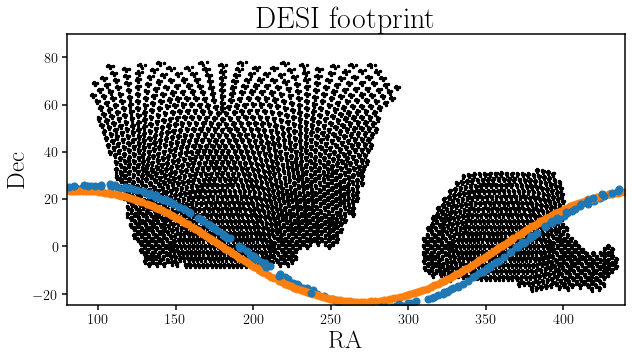

In [6]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(((tiles['RA'][in_desi] - 80) % 360) + 80, tiles['DEC'][in_desi], s=5, c='k')
#sub.scatter(tiles['RA'][in_desi], tiles['DEC'][in_desi], s=5, c='k')

for month in range(1,13): 
    if month == 2: days = 28
    else: days = 30
    for day in range(1,days+1)[::2]: 
        tt = Time(datetime(2021, month, day, 12, 0, 0), scale='utc')
        _sun = get_sun(tt)
        sub.scatter(((_sun.ra.to(u.deg).value - 80) % 360) + 80, _sun.dec, c='C1', s=50)

        _moon = get_moon(tt)
        sub.scatter(((_moon.ra.to(u.deg).value - 80) % 360) + 80, _moon.dec, c='C0', s=50)

sub.set_xlabel('RA', fontsize=25)
sub.set_xlim(80, 440)
sub.set_ylabel('Dec', fontsize=25)
sub.set_ylim(-25., 90.)
sub.set_title('DESI footprint', fontsize=30)

In [7]:
is_bgs = in_desi & (tiles['PROGRAM'] == 'BRIGHT')

Text(0.5, 1.0, 'BGS footprint')

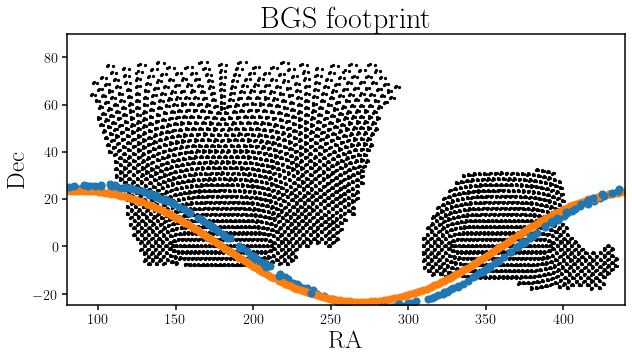

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(((tiles['RA'][is_bgs] - 80) % 360) + 80, tiles['DEC'][is_bgs], s=5, c='k')

for month in range(1,13): 
    if month == 2: days = 28
    else: days = 30
    for day in range(1,days+1)[::2]: 
        tt = Time(datetime(2021, month, day, 12, 0, 0), scale='utc')
        _sun = get_sun(tt)
        sub.scatter(((_sun.ra.to(u.deg).value - 80) % 360) + 80, _sun.dec, c='C1', s=50)

        _moon = get_moon(tt)
        sub.scatter(((_moon.ra.to(u.deg).value - 80) % 360) + 80, _moon.dec, c='C0', s=50)

sub.set_xlabel('RA', fontsize=25)
sub.set_xlim(80, 440)
sub.set_ylabel('Dec', fontsize=25)
sub.set_ylim(-25., 90.)
sub.set_title('BGS footprint', fontsize=30)